# **Who cut my card?**
### Given personal, banking history and credit card transactions, which customers are likely to cancel their credit card?

<br>

## Approach
1. Data is in the form of 3 different datasets. I want to submit only one dataset to the model so I will merge the 3 datasets into one.
2. For each data set, examine the features - what feature should be categorical, what features can we engineer from existing data?
3. Examine the data as a whole, what does our data look like, do we have any outliers, is our data skewed, what features will be good predictors?

<br>
IMPORTS


In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

import seaborn as sns
SEED = 14

#### Create folder structure

In [84]:
import os
for d in ['orig\data', 'output']:
    os.makedirs(d, exist_ok=True)

#### Import accounts.csv data to dataframe

In [85]:
df_accounts = pd.read_csv("orig/accounts_train.csv")
print(df_accounts.shape)
df_accounts.head(10)

(25012, 2)


,Customer,Account
0,828247016,Investment
1,828247016,Current
2,828247016,Credit Card
3,828247016,On Demand Deposit
4,828247016,Mortgage
5,828247016,Joint
6,794487117,On Demand Deposit
7,794487117,Mortgage
8,794487117,Current
9,794487117,Credit Card


<br>

### First of all, make each account a binary feature as each account customer relates to multiple accounts. This will give us one observation per customer


In [86]:
cols = df_accounts.Account.unique()


In [87]:
df_accounts2 = pd.DataFrame(columns ={'Investment', 'Current', 'Credit_Card', 'On_Demand_Deposit','Mortgage', 'Joint', 'Deposit', 'Loan'})
df_accounts2

,Credit_Card,Joint,Investment,Deposit,Mortgage,On_Demand_Deposit,Loan,Current


In [88]:
frames = [df_accounts,df_accounts2]
df_accounts3 = pd.concat(frames)
df_accounts3

,Customer,Account,Credit_Card,Joint,Investment,Deposit,Mortgage,On_Demand_Deposit,Loan,Current
0,828247016.0,Investment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,828247016.0,Current,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,828247016.0,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,828247016.0,On Demand Deposit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,828247016.0,Mortgage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
25007,812694049.0,Deposit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25008,812694049.0,Mortgage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25009,812694049.0,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25010,812694049.0,Investment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
df_accounts3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25012 entries, 0 to 25011
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer           25012 non-null  float64
 1   Account            25012 non-null  object 
 2   Credit_Card        0 non-null      object 
 3   Joint              0 non-null      object 
 4   Investment         0 non-null      object 
 5   Deposit            0 non-null      object 
 6   Mortgage           0 non-null      object 
 7   On_Demand_Deposit  0 non-null      object 
 8   Loan               0 non-null      object 
 9   Current            0 non-null      object 
dtypes: float64(1), object(9)
memory usage: 2.1+ MB


<br>

#### If the customer has the account type set the value to 1, otherwise, set to 0

Supress warnings (makes it easier to read the notebook!)

In [90]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [91]:
df_accounts3['On_Demand_Deposit'].loc[df_accounts3['Account']=='On Demand Deposit'] = 1
df_accounts3['Credit_Card'].loc[df_accounts3['Account']=='Credit Card'] = 1
df_accounts3['Loan'].loc[df_accounts3['Account']=='Loan'] = 1
df_accounts3['Joint'].loc[df_accounts3['Account']=='Joint'] = 1
df_accounts3['Deposit'].loc[df_accounts3['Account']=='Deposit'] = 1
df_accounts3['Mortgage'].loc[df_accounts3['Account']=='Mortgage'] = 1
df_accounts3['Current'].loc[df_accounts3['Account']=='Current'] = 1
df_accounts3['Investment'].loc[df_accounts3['Account']=='Investment'] = 1



df_accounts3=df_accounts3.fillna(0)

In [92]:
df_accounts3 = df_accounts3.drop_duplicates()

#### Add a feature that will say how many accounts a customer has - num_accs

In [93]:
df_accounts3_count = df_accounts3.groupby(['Customer']).count().reset_index()
df_accounts3_count = df_accounts3_count.rename(columns ={"Account": "num_accs"})
df_accounts4_count= df_accounts3_count[["Customer", "num_accs"]]
df_accounts4_count

,Customer,num_accs
0,708115009.0,1
1,708117651.0,2
2,708163600.0,3
3,708166361.0,4
4,708169780.0,2
...,...,...
6572,828277434.0,3
6573,828283866.0,3
6574,828288658.0,6
6575,828290781.0,2


Merge the num_accs to the accounts dataframe

In [94]:
df_accounts4 = (pd.merge(df_accounts4_count, df_accounts3, on='Customer'))
df_accounts4

,Customer,num_accs,Account,Credit_Card,Joint,Investment,Deposit,Mortgage,On_Demand_Deposit,Loan,Current
0,708115009.0,1,Credit Card,1,0,0,0,0,0,0,0
1,708117651.0,2,Current,0,0,0,0,0,0,0,1
2,708117651.0,2,Credit Card,1,0,0,0,0,0,0,0
3,708163600.0,3,On Demand Deposit,0,0,0,0,0,1,0,0
4,708163600.0,3,Credit Card,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
24859,828288658.0,6,On Demand Deposit,0,0,0,0,0,1,0,0
24860,828288658.0,6,Mortgage,0,0,0,0,1,0,0,0
24861,828290781.0,2,Credit Card,1,0,0,0,0,0,0,0
24862,828290781.0,2,Current,0,0,0,0,0,0,0,1


Drop the Account column as it is no longer required (it is now a set of binary features)

In [95]:
df_accounts4 = df_accounts4.drop(columns='Account')


In [96]:
df_accounts4

,Customer,num_accs,Credit_Card,Joint,Investment,Deposit,Mortgage,On_Demand_Deposit,Loan,Current
0,708115009.0,1,1,0,0,0,0,0,0,0
1,708117651.0,2,0,0,0,0,0,0,0,1
2,708117651.0,2,1,0,0,0,0,0,0,0
3,708163600.0,3,0,0,0,0,0,1,0,0
4,708163600.0,3,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
24859,828288658.0,6,0,0,0,0,0,1,0,0
24860,828288658.0,6,0,0,0,0,1,0,0,0
24861,828290781.0,2,1,0,0,0,0,0,0,0
24862,828290781.0,2,0,0,0,0,0,0,0,1


In [97]:
df_accounts4.Customer.astype(int)

0        708115009
1        708117651
2        708117651
3        708163600
4        708163600
           ...    
24859    828288658
24860    828288658
24861    828290781
24862    828290781
24863    828317722
Name: Customer, Length: 24864, dtype: int32

In [98]:
df_accounts4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24864 entries, 0 to 24863
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer           24864 non-null  float64
 1   num_accs           24864 non-null  int64  
 2   Credit_Card        24864 non-null  int64  
 3   Joint              24864 non-null  int64  
 4   Investment         24864 non-null  int64  
 5   Deposit            24864 non-null  int64  
 6   Mortgage           24864 non-null  int64  
 7   On_Demand_Deposit  24864 non-null  int64  
 8   Loan               24864 non-null  int64  
 9   Current            24864 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 2.1 MB


#### Import the customer.csv data into a data frame

In [99]:
df_customers = pd.read_csv("orig/customers_train.csv")
print(df_customers.shape)
df_customers.head(10)

(6577, 15)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K
5,764982590,No,Silver,2018-10-01,4,6036.0,1409,4627.0,0.233,56.0,M,PhD,Married,2,€50K - €80K
6,726241334,No,Platinum,2019-02-01,1,34516.0,1464,33052.0,0.042,52.0,M,Post LC,Married,0,€100K +
7,816118170,Yes,Silver,2020-01-01,2,1819.0,725,1094.0,0.399,NaN,M,Graduate,Single,1,€50K - €80K
8,794814582,No,Silver,2021-04-01,2,2591.0,2340,251.0,0.903,33.0,F,Graduate,Married,1,Less than €30K
9,782671532,No,Silver,2019-02-01,3,1438.3,0,1438.3,0.000,61.0,F,Unknown,Married,1,Unknown


In [100]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6577 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer                   6577 non-null   int64  
 1   Churn                      6556 non-null   object 
 2   Card                       6577 non-null   object 
 3   Start_Date                 6577 non-null   object 
 4   Customer_Service_Calls     6577 non-null   int64  
 5   Credit_Limit               6577 non-null   float64
 6   Total_Revolving_Balance    6577 non-null   int64  
 7   Average_Open_To_Buy        6577 non-null   float64
 8   Average_Utilisation_Ratio  6577 non-null   float64
 9   Age                        6312 non-null   float64
 10  Gender                     6577 non-null   object 
 11  Education                  6577 non-null   object 
 12  Marital_Status             6102 non-null   object 
 13  Dependents                 6577 non-null   int64

Instead of start date calc how many months active

#### We have some observations that does not have a predicted value - I am going to drop these

In [101]:
df_customers['Churn'].replace('', np.nan, inplace=True)
df_customers.dropna(subset=['Churn'], inplace=True)
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6576
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer                   6556 non-null   int64  
 1   Churn                      6556 non-null   object 
 2   Card                       6556 non-null   object 
 3   Start_Date                 6556 non-null   object 
 4   Customer_Service_Calls     6556 non-null   int64  
 5   Credit_Limit               6556 non-null   float64
 6   Total_Revolving_Balance    6556 non-null   int64  
 7   Average_Open_To_Buy        6556 non-null   float64
 8   Average_Utilisation_Ratio  6556 non-null   float64
 9   Age                        6291 non-null   float64
 10  Gender                     6556 non-null   object 
 11  Education                  6556 non-null   object 
 12  Marital_Status             6081 non-null   object 
 13  Dependents                 6556 non-null   int64

#### Create a feature based on start date that will be the number of months the account/customer has been with the bank

In [102]:
df_customers.Start_Date = pd.to_datetime(df_customers.Start_Date)
df_customers['nb_months'] = ((pd.to_datetime("today") - df_customers.Start_Date)/np.timedelta64(1, 'M'))
df_customers['nb_months'] = df_customers['nb_months'].astype(int)
df_customers

,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,Gender,Education,Marital_Status,Dependents,Income,nb_months
0,797197508,No,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,F,Graduate,Married,2,Less than €30K,35
1,812854728,No,Silver,2020-01-01,1,7645.0,2076,5569.0,0.272,58.0,F,Second level,Single,5,Less than €30K,40
2,768000743,No,Silver,2020-01-01,2,6394.0,0,6394.0,0.000,55.0,F,Second level,Single,2,Less than €30K,40
3,722161439,No,Silver,2020-08-01,3,4663.0,0,4663.0,0.000,41.0,F,Graduate,NaN,2,€30K - €50K,33
4,759029725,No,Silver,2021-02-01,4,1879.0,1486,393.0,0.791,37.0,F,Second level,Single,1,Less than €30K,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6572,785444639,No,Silver,2020-01-01,3,3832.0,1439,2393.0,0.376,58.0,F,Unknown,Married,0,Less than €30K,40
6573,757416641,No,Silver,2019-08-01,2,4167.0,0,4167.0,0.000,60.0,F,Post LC,Married,2,Less than €30K,45
6574,817395226,No,Silver,2019-12-01,2,2470.0,2013,457.0,0.815,42.0,F,Graduate,Married,3,€30K - €50K,41
6575,732032194,No,Silver,2020-01-01,2,8138.0,2104,6034.0,0.259,NaN,F,Second level,Married,0,Unknown,40


For unknown age set the age to the median and record where age was not set

In [103]:
df_customers.insert(loc=10, column = 'Age_was_NA',value=0)

In [104]:
df_customers['Age_was_NA'].loc[df_customers['Age'].isnull()] = 1

In [105]:
median_age = df_customers.Age.median()
median_age

48.0

In [106]:
df_customers['Age'].loc[df_customers['Age'].isnull()] = median_age

In [107]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6576
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   object        
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   object        
 12  Educat

#### What % of customers churn

In [108]:
df_customers.Churn.value_counts(normalize=True)

No     0.842282
Yes    0.157718
Name: Churn, dtype: float64

### Import the transactions.csv data to a dataframe

In [109]:
df_transactions = pd.read_csv("orig/transactions_train.csv")
print(df_transactions.shape)
df_transactions.head(5)

(514611, 3)


,Customer,Date,Amount
0,828247016,2022-03-01,70.94
1,828247016,2022-02-21,52.16
2,828247016,2022-02-19,67.03
3,828247016,2022-02-19,48.24
4,828247016,2022-05-20,10.97


In [110]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514611 entries, 0 to 514610
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Customer  514611 non-null  int64  
 1   Date      514611 non-null  object 
 2   Amount    514611 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ MB


### Create a feature for the number of transactions

In [111]:
df_transactions_count = df_transactions.groupby(['Customer']).count().reset_index()
df_transactions_count = df_transactions_count.rename(columns ={"Date": "num_trans"})
df_transactions_count= df_transactions_count.drop(columns =["Amount"])
df_transactions_count

,Customer,num_trans
0,708115009,36
1,708117651,86
2,708163600,104
3,708166361,72
4,708169780,78
...,...,...
7874,828277434,72
7875,828283866,75
7876,828288658,68
7877,828290781,92


### Aggregate the transaction per customer

In [112]:
df_transactions = df_transactions.groupby(['Customer']).sum(['Amount']).reset_index()
df_transactions

,Customer,Amount
0,708115009,1886.99
1,708117651,7400.03
2,708163600,13299.99
3,708166361,4107.99
4,708169780,4539.95
...,...,...
7874,828277434,4079.99
7875,828283866,4464.00
7876,828288658,4273.98
7877,828290781,8160.02


Merge both dataframes together and we have one dataset with one row per customer

In [113]:
df_transactions2 = (pd.merge(df_transactions_count, df_transactions, on='Customer'))
df_transactions2

,Customer,num_trans,Amount
0,708115009,36,1886.99
1,708117651,86,7400.03
2,708163600,104,13299.99
3,708166361,72,4107.99
4,708169780,78,4539.95
...,...,...,...
7874,828277434,72,4079.99
7875,828283866,75,4464.00
7876,828288658,68,4273.98
7877,828290781,92,8160.02


### Identify Categorical and numerical features
Looking at the customer df only initially

for null marital status set to unkown and record where it was previously null


In [114]:
df_customers.insert(loc=14, column = 'M_Stat_was_NA',value=0)

In [115]:
df_customers['M_Stat_was_NA'].loc[df_customers['Marital_Status'].isnull()] = 1

In [116]:
df_customers['Marital_Status'].loc[df_customers['Marital_Status'].isnull()] = 'Unknown'

In [117]:
df_customers.Gender = pd.Categorical(df_customers.Gender)
df_customers.Marital_Status = pd.Categorical(df_customers.Marital_Status)
df_customers.Card = pd.Categorical(df_customers.Card)
df_customers.Income = pd.Categorical(df_customers.Income)
#df_customers.Churn = pd.Categorical(df_customers.Churn)

In [118]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6556 entries, 0 to 6576
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   6556 non-null   int64         
 1   Churn                      6556 non-null   object        
 2   Card                       6556 non-null   category      
 3   Start_Date                 6556 non-null   datetime64[ns]
 4   Customer_Service_Calls     6556 non-null   int64         
 5   Credit_Limit               6556 non-null   float64       
 6   Total_Revolving_Balance    6556 non-null   int64         
 7   Average_Open_To_Buy        6556 non-null   float64       
 8   Average_Utilisation_Ratio  6556 non-null   float64       
 9   Age                        6556 non-null   float64       
 10  Age_was_NA                 6556 non-null   int64         
 11  Gender                     6556 non-null   category      
 12  Educat

### Merge the customer and accounts dataframes

In [119]:
df_cust_acc = (pd.merge(df_customers, df_accounts4, on='Customer'))

In [120]:
df_cust_acc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24790 entries, 0 to 24789
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   24790 non-null  int64         
 1   Churn                      24790 non-null  object        
 2   Card                       24790 non-null  category      
 3   Start_Date                 24790 non-null  datetime64[ns]
 4   Customer_Service_Calls     24790 non-null  int64         
 5   Credit_Limit               24790 non-null  float64       
 6   Total_Revolving_Balance    24790 non-null  int64         
 7   Average_Open_To_Buy        24790 non-null  float64       
 8   Average_Utilisation_Ratio  24790 non-null  float64       
 9   Age                        24790 non-null  float64       
 10  Age_was_NA                 24790 non-null  int64         
 11  Gender                     24790 non-null  category      
 12  Educ

In [121]:
df_cust_acc.On_Demand_Deposit = pd.Categorical(df_cust_acc.On_Demand_Deposit)
df_cust_acc.Investment = pd.Categorical(df_cust_acc.Investment)
df_cust_acc.Credit_Card = pd.Categorical(df_cust_acc.Credit_Card)
df_cust_acc.Loan = pd.Categorical(df_cust_acc.Loan)
df_cust_acc.Joint = pd.Categorical(df_cust_acc.Joint)
df_cust_acc.Mortgage = pd.Categorical(df_cust_acc.Mortgage)
df_cust_acc.Current = pd.Categorical(df_cust_acc.Current)
df_cust_acc.Deposit = pd.Categorical(df_cust_acc.Deposit)
df_cust_acc.Education = pd.Categorical(df_cust_acc.Education)

In [122]:
df_cust_acc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24790 entries, 0 to 24789
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   24790 non-null  int64         
 1   Churn                      24790 non-null  object        
 2   Card                       24790 non-null  category      
 3   Start_Date                 24790 non-null  datetime64[ns]
 4   Customer_Service_Calls     24790 non-null  int64         
 5   Credit_Limit               24790 non-null  float64       
 6   Total_Revolving_Balance    24790 non-null  int64         
 7   Average_Open_To_Buy        24790 non-null  float64       
 8   Average_Utilisation_Ratio  24790 non-null  float64       
 9   Age                        24790 non-null  float64       
 10  Age_was_NA                 24790 non-null  int64         
 11  Gender                     24790 non-null  category      
 12  Educ

In [123]:
df_cust_acc_tran = (pd.merge(df_cust_acc, df_transactions2, on='Customer'))

In [124]:
df_cust_acc_tran.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24790 entries, 0 to 24789
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Customer                   24790 non-null  int64         
 1   Churn                      24790 non-null  object        
 2   Card                       24790 non-null  category      
 3   Start_Date                 24790 non-null  datetime64[ns]
 4   Customer_Service_Calls     24790 non-null  int64         
 5   Credit_Limit               24790 non-null  float64       
 6   Total_Revolving_Balance    24790 non-null  int64         
 7   Average_Open_To_Buy        24790 non-null  float64       
 8   Average_Utilisation_Ratio  24790 non-null  float64       
 9   Age                        24790 non-null  float64       
 10  Age_was_NA                 24790 non-null  int64         
 11  Gender                     24790 non-null  category      
 12  Educ

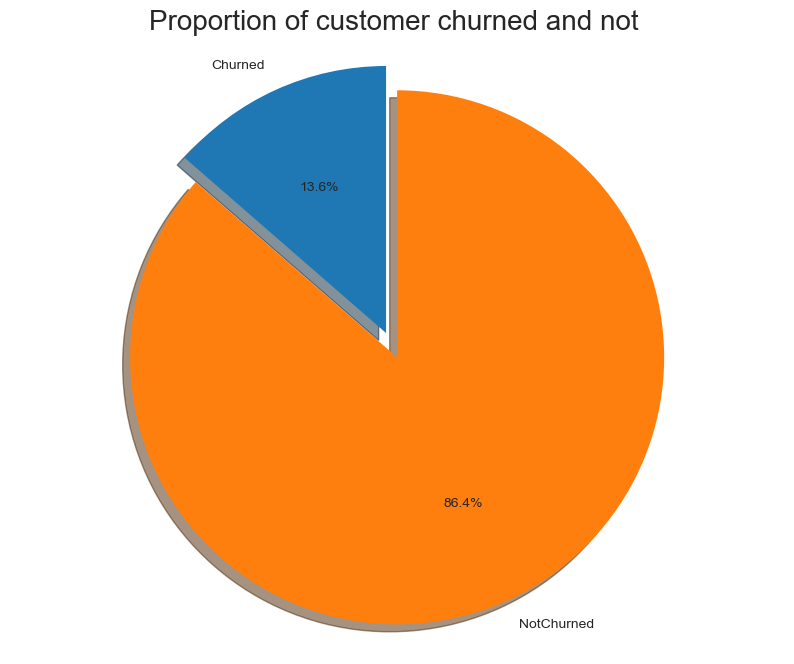

In [125]:
labels = 'Churned', 'NotChurned'
sizes = [df_cust_acc_tran.Churn[df_cust_acc_tran['Churn']=='Yes'].count(), df_cust_acc_tran.Churn[df_cust_acc_tran['Churn']=='No'].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and not ", size = 20)
plt.show()

The dataset is imbalanced as the number of churned is only 15% vs the number not churned is 84%
We will use recall and cross validation scoring

#### Relationship of Churned with categorical variables

<AxesSubplot:xlabel='Investment', ylabel='count'>

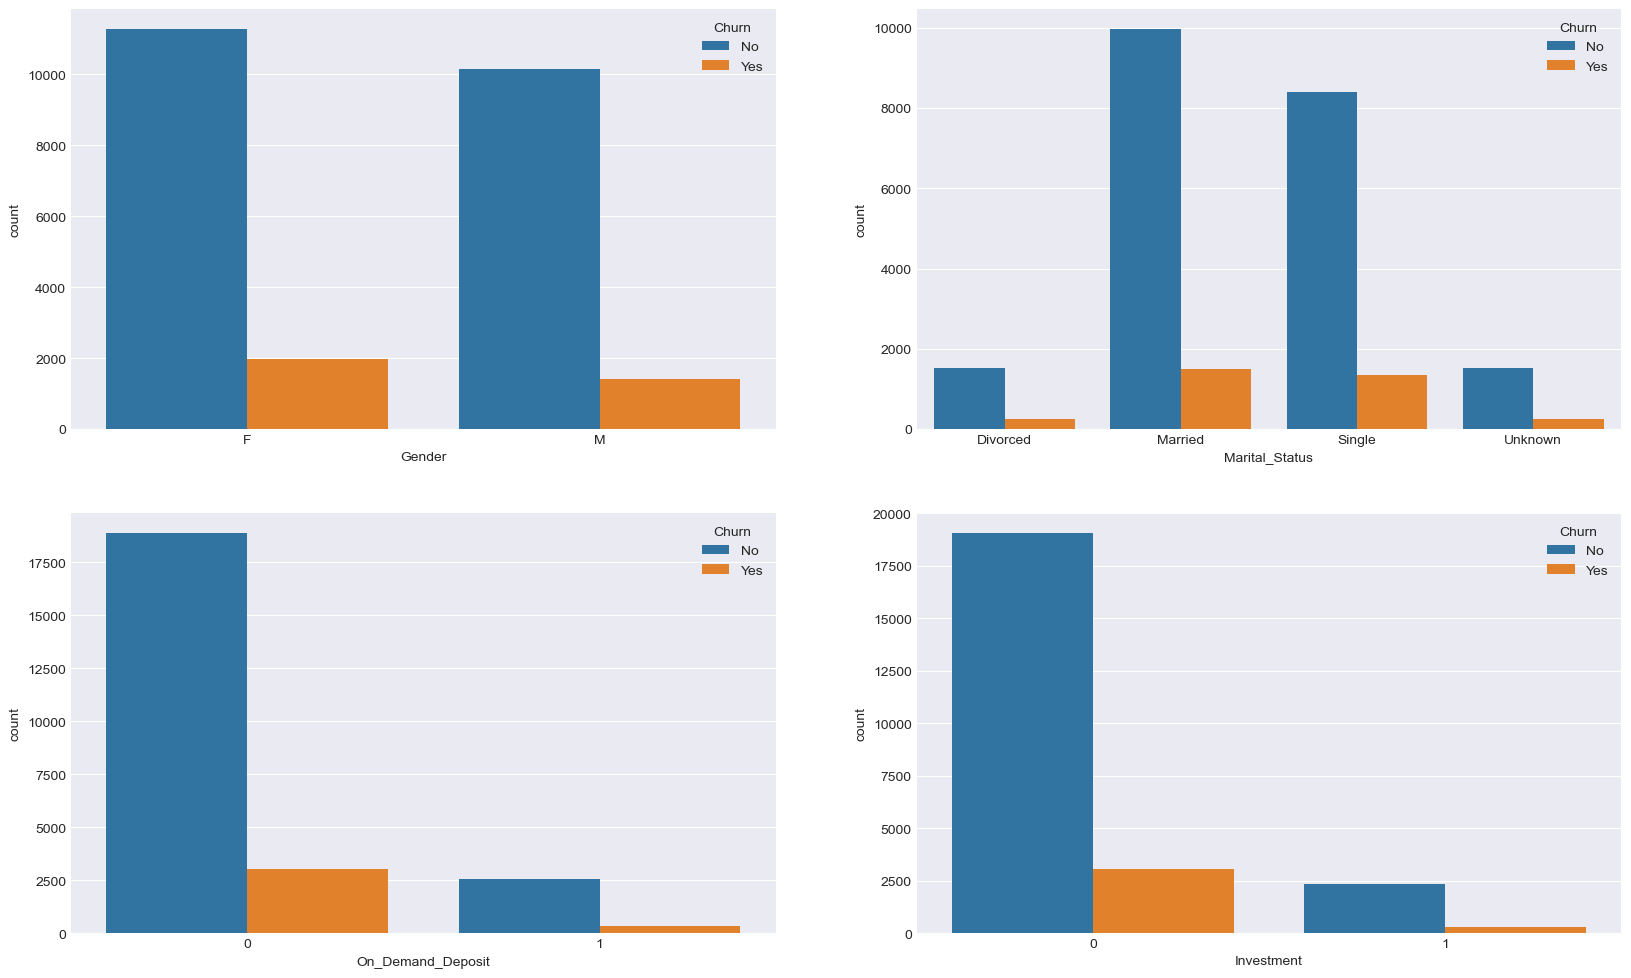

In [126]:

    fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
    sns.countplot(x='Gender', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
    sns.countplot(x='Marital_Status', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
    sns.countplot(x='On_Demand_Deposit', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
    sns.countplot(x='Investment', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])
   


<AxesSubplot:xlabel='Mortgage', ylabel='count'>

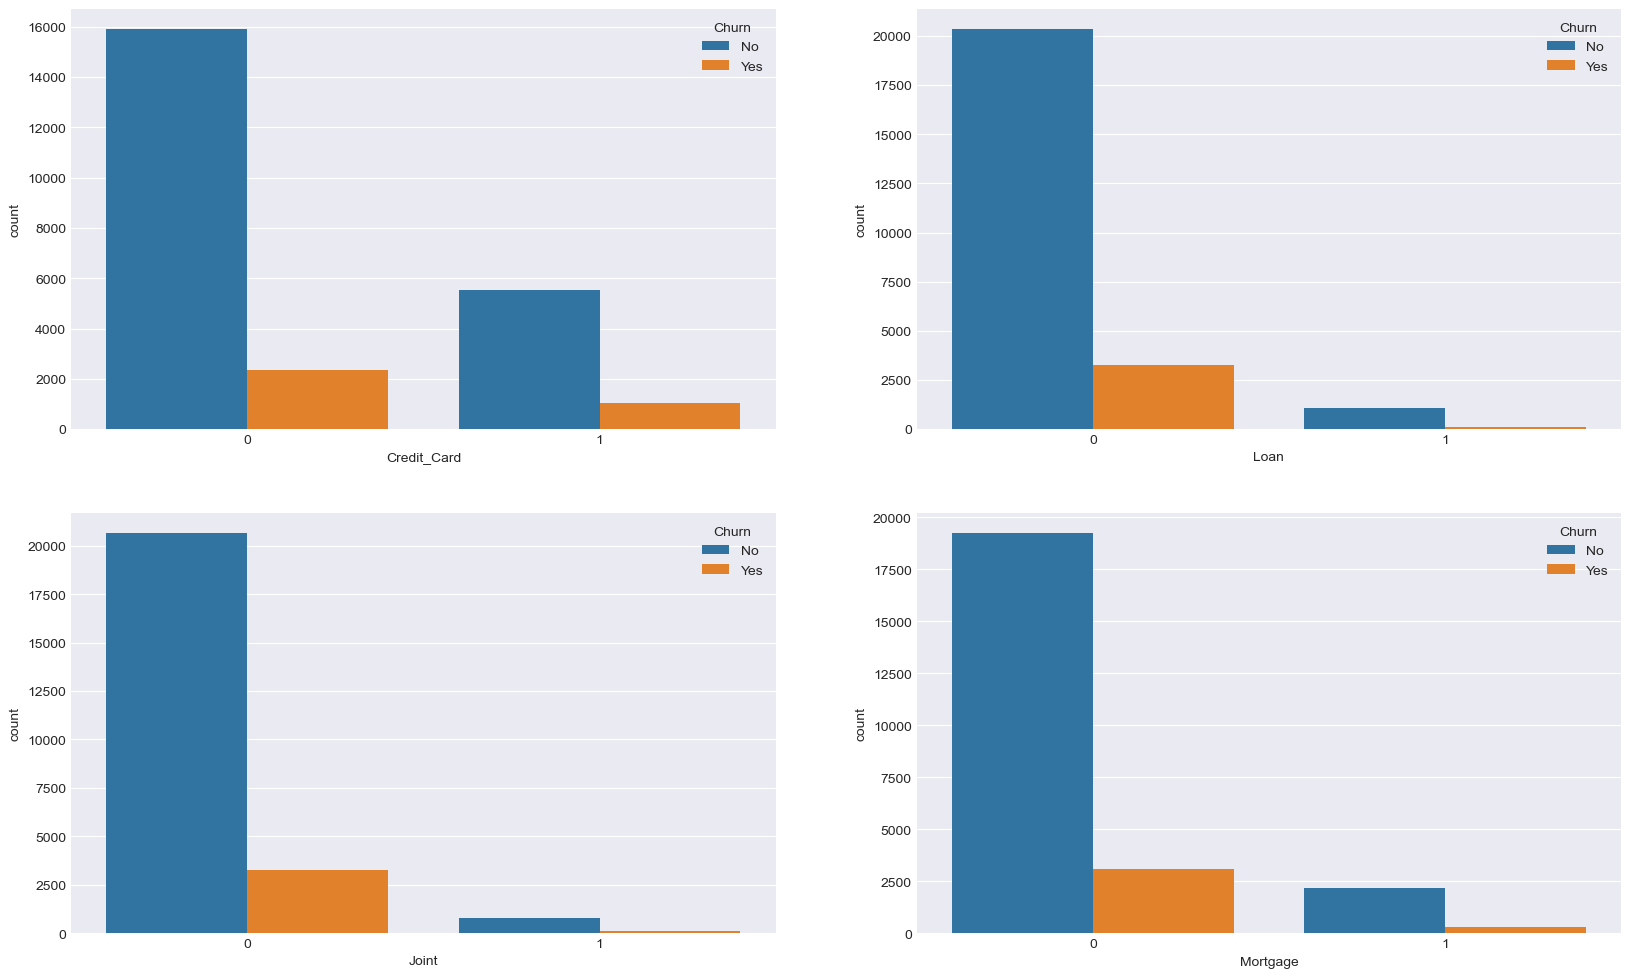

In [127]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Credit_Card', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.countplot(x='Loan', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
sns.countplot(x='Joint', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
sns.countplot(x='Mortgage', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])

<AxesSubplot:xlabel='Income', ylabel='count'>

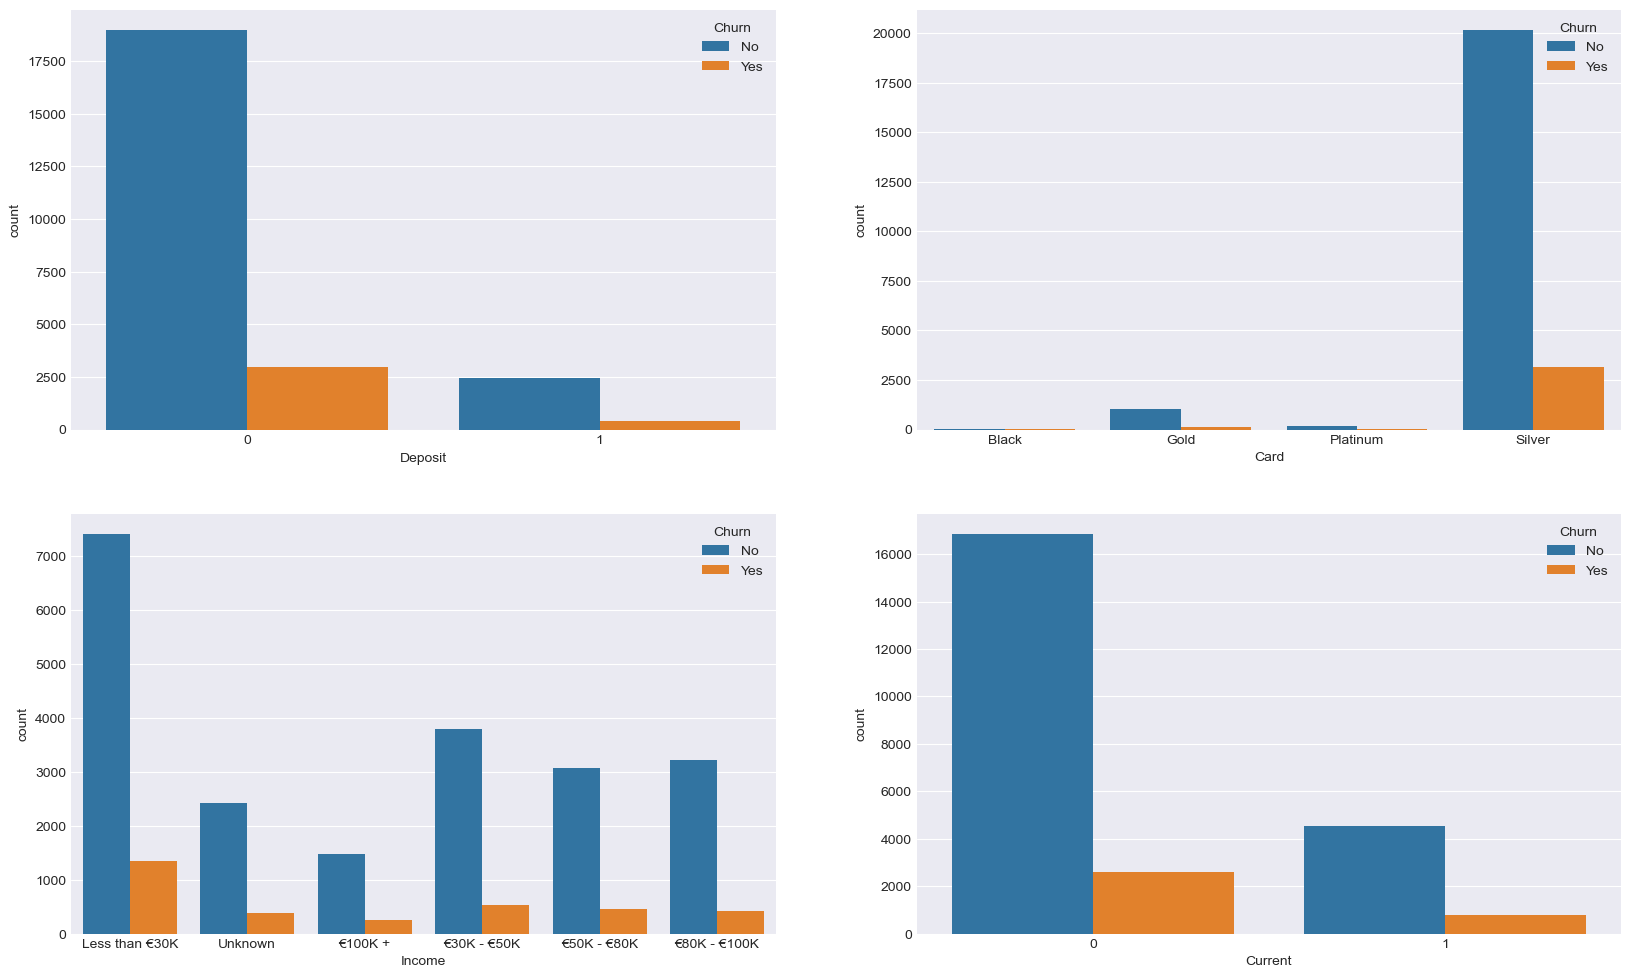

In [128]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Current', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])
sns.countplot(x='Deposit', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.countplot(x='Card', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
sns.countplot(x='Income', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])

<AxesSubplot:xlabel='Education', ylabel='count'>

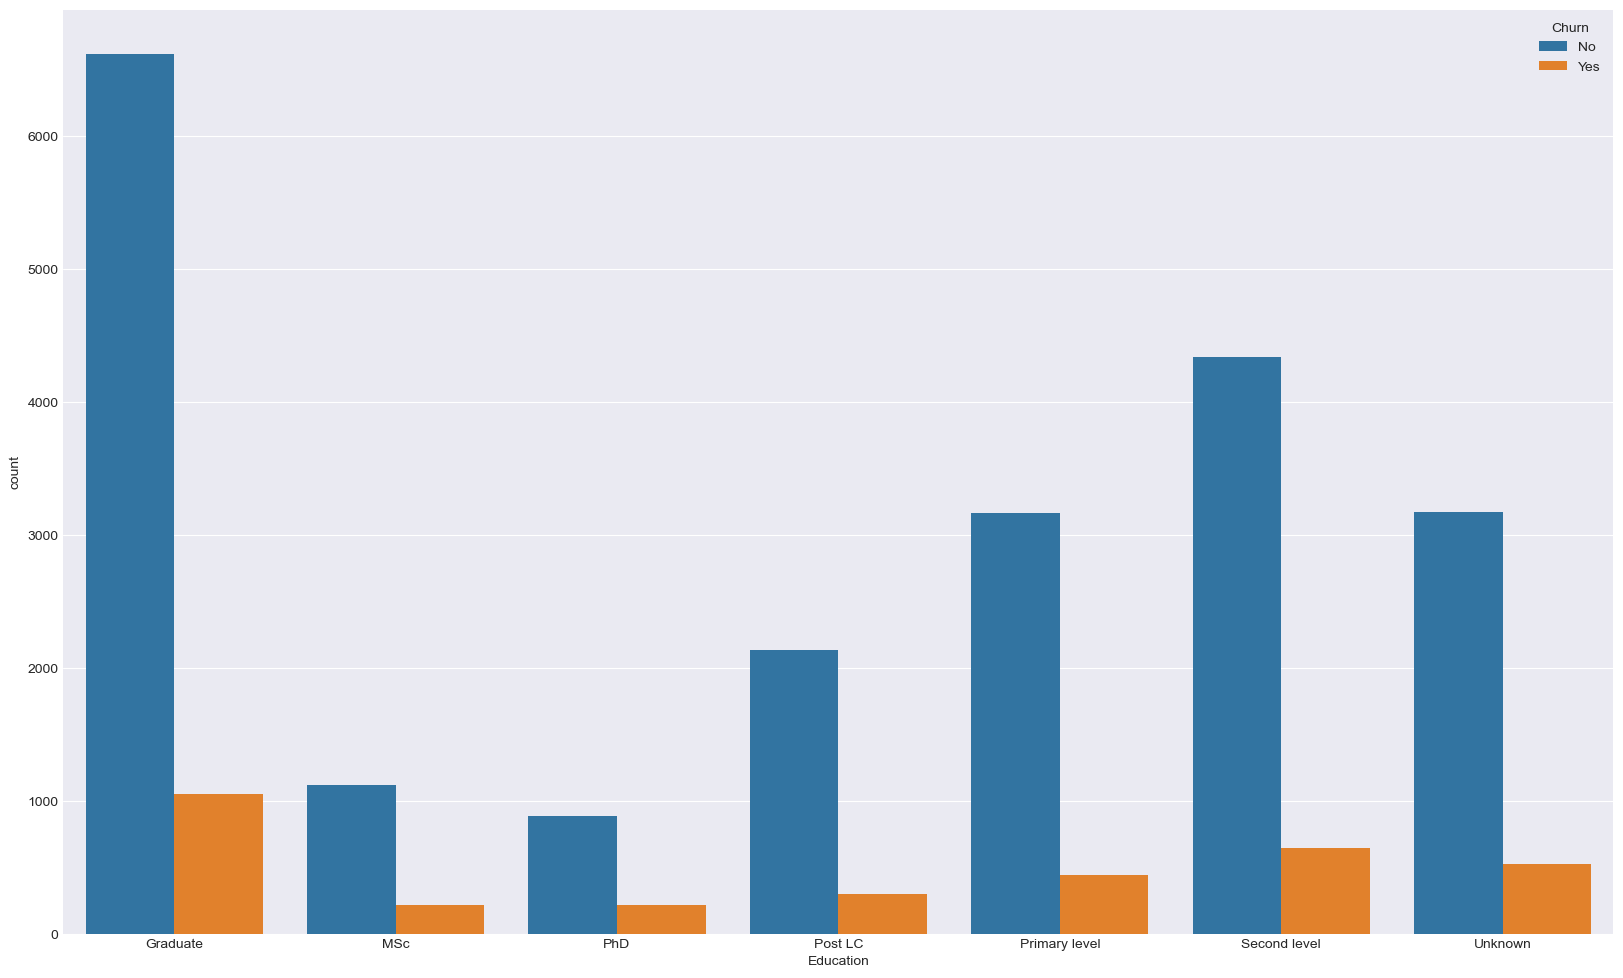

In [129]:
 fig, axarr = plt.subplots(1, 1, figsize=(20, 12))
 sns.countplot(x='Education', hue = 'Churn',data = df_cust_acc_tran, ax=axarr)    

Relationship based on numerical features

<AxesSubplot:xlabel='Churn', ylabel='Amount'>

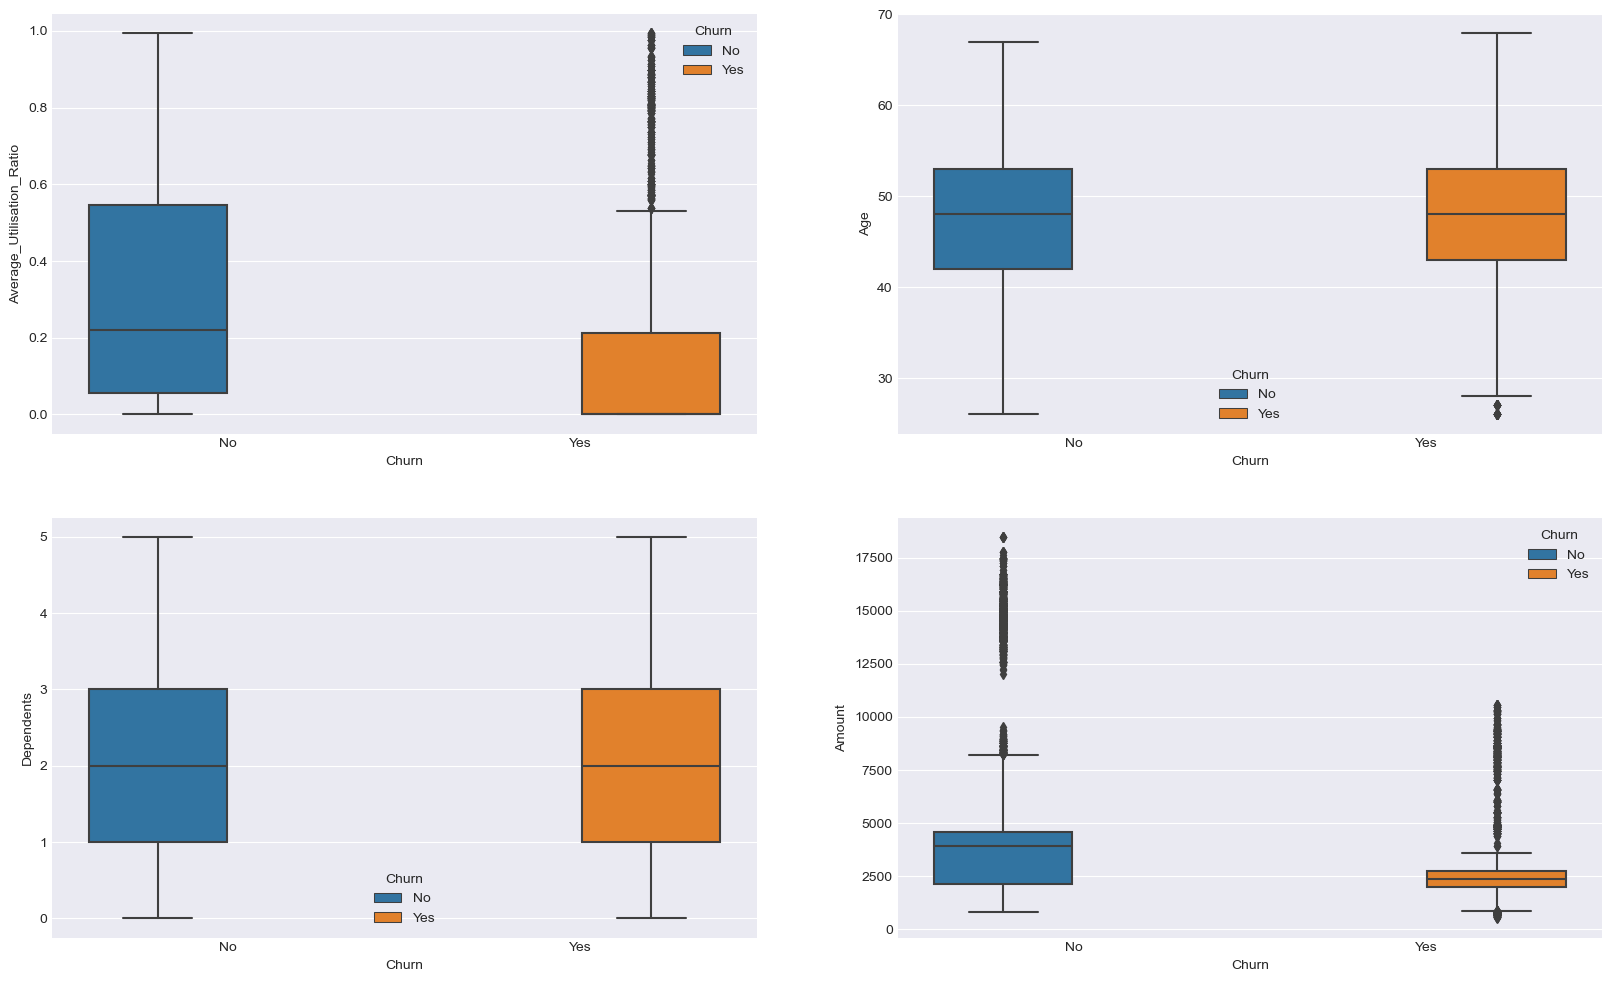

In [130]:

fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='Average_Utilisation_Ratio',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][1])
sns.boxplot(y='Dependents',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
sns.boxplot(y='Amount',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])

<AxesSubplot:xlabel='Churn', ylabel='Average_Open_To_Buy'>

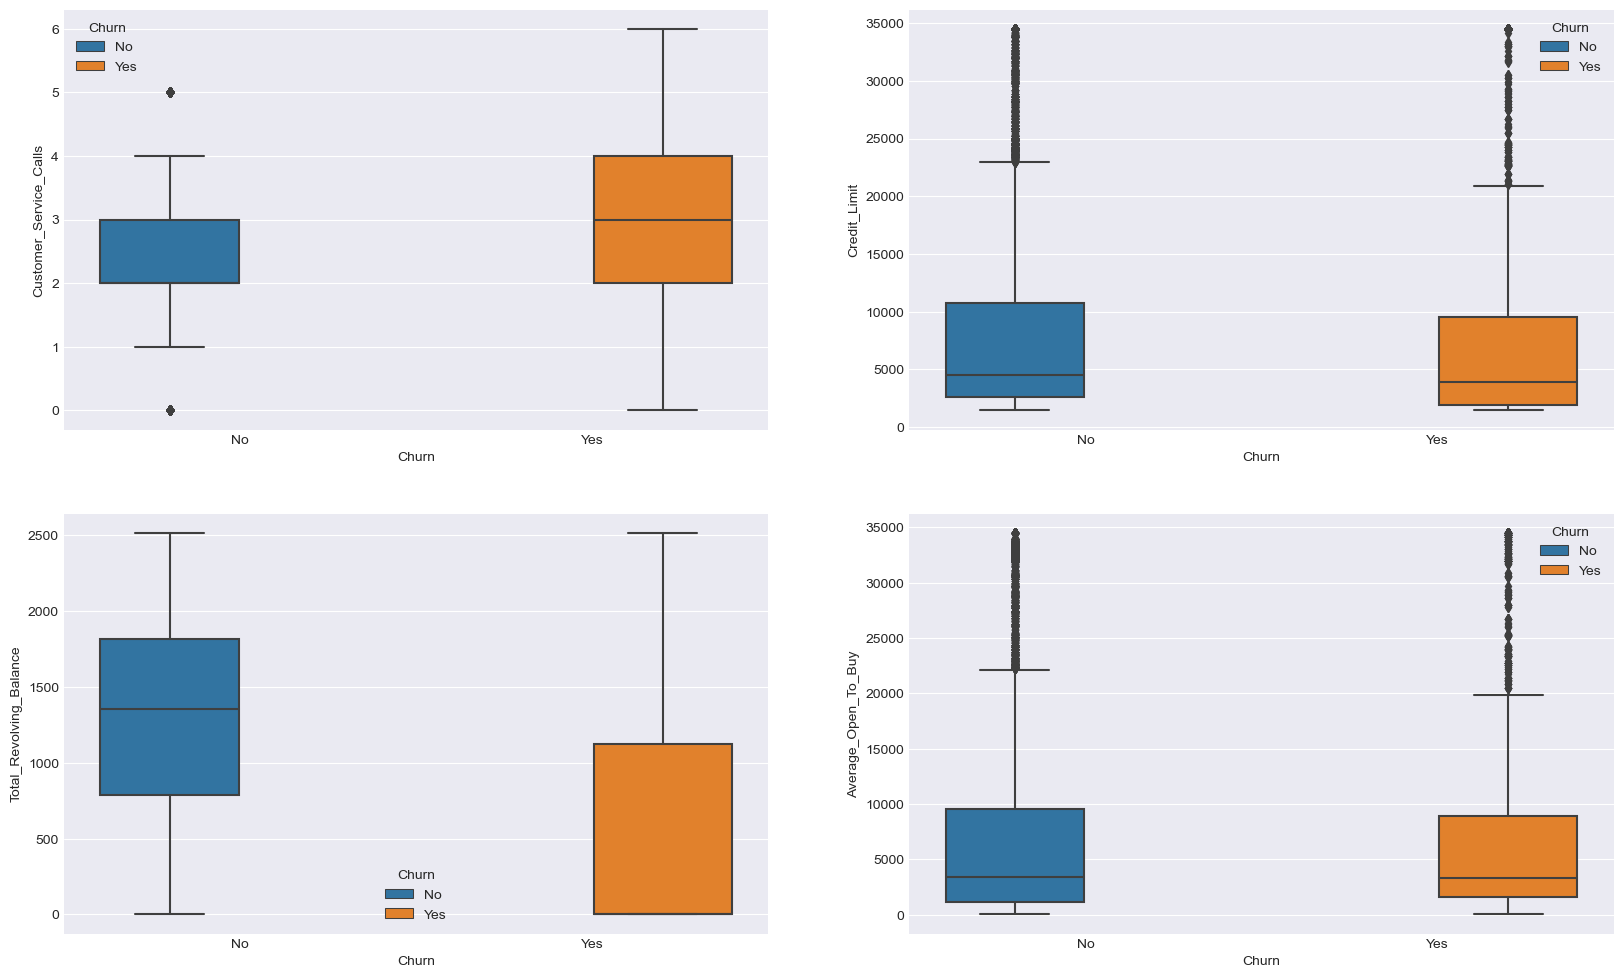

In [131]:
 fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='Customer_Service_Calls',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.boxplot(y='Credit_Limit',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran , ax=axarr[0][1])
sns.boxplot(y='Total_Revolving_Balance',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])
sns.boxplot(y='Average_Open_To_Buy',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][1])

<AxesSubplot:xlabel='Churn', ylabel='nb_months'>

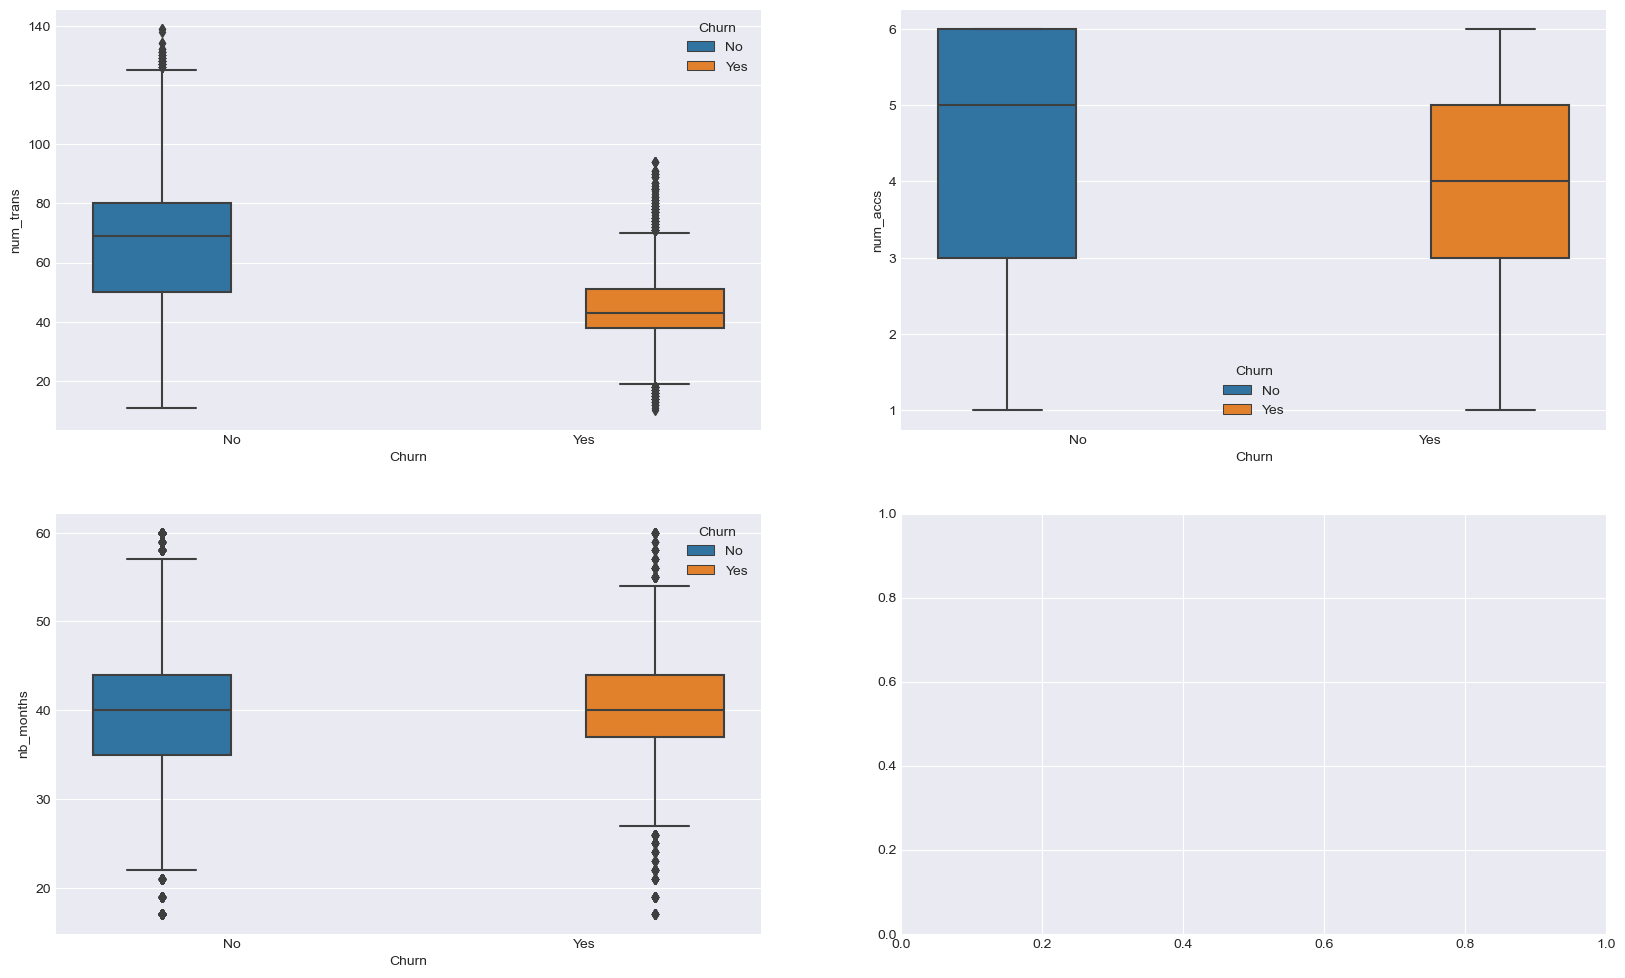

In [132]:
 fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.boxplot(y='num_trans',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[0][0])
sns.boxplot(y='num_accs',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran , ax=axarr[0][1])
sns.boxplot(y='nb_months',x = 'Churn', hue = 'Churn',data = df_cust_acc_tran, ax=axarr[1][0])


# To Do Summarize what these graphs tell us

In [133]:
df_cust_acc_tran['Churn'].loc[df_cust_acc_tran['Churn']=='Yes'] = 1
df_cust_acc_tran['Churn'].loc[df_cust_acc_tran['Churn']=='No'] = 0

In [134]:
df_cust_acc_tran.Churn = pd.Categorical(df_cust_acc_tran.Churn)
df_cust_acc_tran


C:\Users\mccab\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,Customer,Churn,Card,Start_Date,Customer_Service_Calls,Credit_Limit,Total_Revolving_Balance,Average_Open_To_Buy,Average_Utilisation_Ratio,Age,...,Credit_Card,Joint,Investment,Deposit,Mortgage,On_Demand_Deposit,Loan,Current,num_trans,Amount
0,797197508,0,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,...,1,0,0,0,0,0,0,0,90,4827.96
1,797197508,0,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,...,0,0,1,0,0,0,0,0,90,4827.96
2,797197508,0,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,...,0,0,0,1,0,0,0,0,90,4827.96
3,797197508,0,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,...,0,0,0,0,1,0,0,0,90,4827.96
4,797197508,0,Silver,2020-06-01,1,2315.0,1565,750.0,0.676,48.0,...,0,0,0,0,0,0,0,1,90,4827.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24785,732032194,0,Silver,2020-01-01,2,8138.0,2104,6034.0,0.259,48.0,...,0,0,1,0,0,0,0,0,29,1299.00
24786,732032194,0,Silver,2020-01-01,2,8138.0,2104,6034.0,0.259,48.0,...,0,0,0,0,0,0,0,1,29,1299.00
24787,759872383,1,Silver,2020-08-01,3,1653.0,0,1653.0,0.000,37.0,...,0,0,0,1,0,0,0,0,35,2284.00
24788,759872383,1,Silver,2020-08-01,3,1653.0,0,1653.0,0.000,37.0,...,1,0,0,0,0,0,0,0,35,2284.00


In [135]:
categorical_features = ['Gender', 'Marital_Status', 'On_Demand_Deposit', 'Investment','Loan', 'Joint', 'Mortgage', 'Current', 'Deposit', 'Card','Income', 'Education']
#categorical_features = ['Gender', 'Marital_Status', 'Card','Income', 'Credit_Card', 'Mortgage']
numerical_features = ['Customer_Service_Calls','Total_Revolving_Balance', 'Average_Utilisation_Ratio','Amount', 'num_trans', 'num_accs', 'nb_months']


#other_features = ['Education']


features = categorical_features + numerical_features #+ other_features

target = 'Churn'

variables = features + [target]

2nd pass we will still drop missing values for now

In [136]:
df_model = df_cust_acc_tran[variables].dropna()
df_model.shape
df_model

,Gender,Marital_Status,On_Demand_Deposit,Investment,Loan,Joint,Mortgage,Current,Deposit,Card,Income,Education,Customer_Service_Calls,Total_Revolving_Balance,Average_Utilisation_Ratio,Amount,num_trans,num_accs,nb_months,Churn
0,F,Married,0,0,0,0,0,0,0,Silver,Less than €30K,Graduate,1,1565,0.676,4827.96,90,5,35,0
1,F,Married,0,1,0,0,0,0,0,Silver,Less than €30K,Graduate,1,1565,0.676,4827.96,90,5,35,0
2,F,Married,0,0,0,0,0,0,1,Silver,Less than €30K,Graduate,1,1565,0.676,4827.96,90,5,35,0
3,F,Married,0,0,0,0,1,0,0,Silver,Less than €30K,Graduate,1,1565,0.676,4827.96,90,5,35,0
4,F,Married,0,0,0,0,0,1,0,Silver,Less than €30K,Graduate,1,1565,0.676,4827.96,90,5,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24785,F,Married,0,1,0,0,0,0,0,Silver,Unknown,Second level,2,2104,0.259,1299.00,29,4,40,0
24786,F,Married,0,0,0,0,0,1,0,Silver,Unknown,Second level,2,2104,0.259,1299.00,29,4,40,0
24787,F,Single,0,0,0,0,0,0,1,Silver,Less than €30K,Second level,3,0,0.000,2284.00,35,3,33,1
24788,F,Single,0,0,0,0,0,0,0,Silver,Less than €30K,Second level,3,0,0.000,2284.00,35,3,33,1


In [137]:
from sklearn.preprocessing import  StandardScaler

In [138]:
scaler = StandardScaler()

In [139]:


df_model[numerical_features] = scaler.fit_transform(df_model[numerical_features])

In [582]:
df_model.to_pickle('output/df_model.pkl')

In [140]:
columns = df_model.columns[10:]
columns

Index(['Income', 'Education', 'Customer_Service_Calls',
       'Total_Revolving_Balance', 'Average_Utilisation_Ratio', 'Amount',
       'num_trans', 'num_accs', 'nb_months', 'Churn'],
      dtype='object')

In [141]:
columns = df_model.columns[10:]
corr = df_model[columns].corr()
corr

,Customer_Service_Calls,Total_Revolving_Balance,Average_Utilisation_Ratio,Amount,num_trans,num_accs,nb_months
Customer_Service_Calls,1.000000,-0.047151,-0.049677,-0.075753,-0.117086,0.026617,0.001772
Total_Revolving_Balance,-0.047151,1.000000,0.626815,0.024417,0.014971,0.024204,0.005596
Average_Utilisation_Ratio,-0.049677,0.626815,1.000000,-0.057802,0.022825,0.052966,-0.013849
Amount,-0.075753,0.024417,-0.057802,1.000000,0.782934,-0.271491,-0.026122
num_trans,-0.117086,0.014971,0.022825,0.782934,1.000000,-0.166265,-0.052117
num_accs,0.026617,0.024204,0.052966,-0.271491,-0.166265,1.000000,-0.012515
nb_months,0.001772,0.005596,-0.013849,-0.026122,-0.052117,-0.012515,1.000000


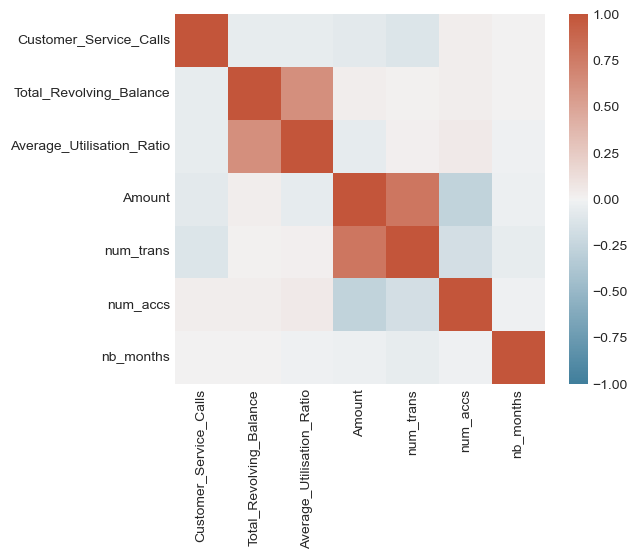

In [142]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=cmap);

### Train / Test Split

In [143]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model[features], df_model.Churn, 
    train_size=0.6, random_state=SEED,stratify=df_model.Churn)

In [144]:
X_train

,Gender,Marital_Status,On_Demand_Deposit,Investment,Loan,Joint,Mortgage,Current,Deposit,Card,Income,Education,Customer_Service_Calls,Total_Revolving_Balance,Average_Utilisation_Ratio,Amount,num_trans,num_accs,nb_months
18642,M,Married,0,0,0,0,0,0,1,Silver,€80K - €100K,Graduate,0.463766,0.682990,-0.814447,-0.187835,0.552953,1.190392,-0.454088
6227,M,Divorced,0,0,0,0,0,0,1,Silver,€30K - €50K,Unknown,-0.429811,-1.440439,-1.014922,-0.915105,-1.821380,-0.299401,1.628538
19278,F,Married,0,0,0,0,0,0,1,Silver,€30K - €50K,Unknown,-0.429811,1.659718,2.096022,-0.836338,-1.182136,1.190392,2.363582
501,M,Unknown,0,0,0,0,0,1,0,Platinum,€50K - €80K,Graduate,0.463766,0.142279,-0.882465,3.950865,2.698985,0.445495,-0.454088
16971,F,Married,0,0,0,0,1,0,0,Silver,Less than €30K,Graduate,1.357342,-1.440439,-1.014922,-0.550970,-0.314592,0.445495,0.035942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6187,F,Married,0,0,0,0,0,1,0,Silver,€30K - €50K,MSc,-0.429811,-0.506820,0.438523,-0.833547,-1.319117,1.190392,0.648479
1802,F,Single,0,0,0,0,0,1,0,Silver,Less than €30K,Graduate,-0.429811,0.636186,1.211784,0.256799,0.507293,-0.299401,0.525971
21647,M,Married,0,0,1,0,0,0,0,Silver,€50K - €80K,MSc,-0.429811,1.430624,0.853793,1.523809,0.187671,1.190392,-1.311639
22804,M,Single,0,0,0,0,0,1,0,Silver,€80K - €100K,Second level,1.357342,-1.440439,-1.014922,-0.086794,0.735594,-0.299401,0.035942


In [145]:
y_train

18642    0
6227     0
19278    0
501      0
16971    1
        ..
6187     0
1802     0
21647    1
22804    0
5011     0
Name: Churn, Length: 14874, dtype: category
Categories (2, int64): [0, 1]

### Import Classifiers

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier

### Build a Pipeline

In [147]:
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
column_transformer = ColumnTransformer([
    # List of transformation to apply and which columns to apply it to. Each entry here has structure 
    #( NAME,                  CODE,                           COLUMNS_TO_APPLY),
    ( 'categorical_features', preprocessing.OneHotEncoder(),  categorical_features ),
    ( 'numerical_features',   preprocessing.StandardScaler(), numerical_features ),
])

In [148]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', LogisticRegression(solver='lbfgs', max_iter=200) ),
])

### Score the model using cross validation scoring function to see how good the initial one is

In [149]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 89.48% +/ 0.16%


### CV estimate of accuracy is 87.26% +/ 0.25%

In [150]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', AdaBoostClassifier() ),
])

In [151]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 94.44% +/ 0.11%


In [152]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='weighted')

0.9450383219039935

In [183]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    #( 'classifier', GradientBoostingClassifier(learning_rate= 1, n_estimators= 200, max_depth= 8.0, min_samples_split= 0.1, min_samples_leaf= 0.1) ),
     ( 'classifier', XGBClassifier() ),
])

In [184]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 98.93% +/ 0.06%


In [185]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='weighted')

0.9938483259378782

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
max_depths = np.linspace(1, 32, 32, endpoint=True)
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
for eta in learning_rates:
    for estimator in n_estimators:
        for max_depth in max_depths:
            for min_samples_split in min_samples_splits:
                for min_samples_leaf in min_samples_leafs:
                    pipeline = Pipeline(steps=[
                        ( 'column_transformer', column_transformer ),
                        ( 'classifier', GradientBoostingClassifier(learning_rate=eta,n_estimators=estimator,max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf) ),
                    ])
                    #scores = cross_val_score(pipeline, X_train, y_train, cv=5)
                    #if(scores.mean()>=0.92):
                        #print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")
                        #print(f"learning_rate= {eta} n_estimators= {estimator} max_depth= {max_depth} min_samples_split= {min_samples_split} min_samples_leaf= {min_samples_leaf}")
                    from sklearn.metrics import recall_score
                    pipeline.fit(X_train, y_train)
                    y_true = y_test
                    y_pred = pipeline.predict(X_test)
                    score = recall_score(y_true, y_pred, average='weighted')
                    if(score > 0.95):
                        print(score)
                        print(f"learning_rate= {eta} n_estimators= {estimator} max_depth= {max_depth} min_samples_split= {min_samples_split} min_samples_leaf= {min_samples_leaf}")

In [160]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', GaussianNB() ),
])

In [161]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 86.46% +/ 0.06%


In [162]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', SVC() ),
])

In [163]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 92.40% +/ 0.07%


In [164]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', RandomForestClassifier() ),
])

In [165]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 98.08% +/ 0.09%


In [174]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='weighted')

0.986385639370714

In [186]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('categorical_features',
                                                  OneHotEncoder(),
                                                  ['Gender', 'Marital_Status',
                                                   'On_Demand_Deposit',
                                                   'Investment', 'Loan',
                                                   'Joint', 'Mortgage',
                                                   'Current', 'Deposit', 'Card',
                                                   'Income', 'Education']),
                                                 ('numerical_features',
                                                  StandardScaler(),
                                                  ['Customer_Service_Calls',
                                                   'Total_Revolving_Balance',
                                                   'Average_Util...
    

In [187]:
filename = "Completed_model_XGB_050220231645.joblib"

In [188]:
import joblib

In [189]:
joblib.dump(pipeline, filename)

['Completed_model_XGB_050220231645.joblib']

In [607]:
y_pred = pipeline.predict(X_test)

In [608]:
y_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [175]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', BernoulliNB() ),
])

In [176]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 87.64% +/ 0.16%


In [177]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='weighted')

0.876663977410246

## CV estimate of accuracy is 83.07% +/ 0.23%

In [178]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ( 'column_transformer', column_transformer ),
    ( 'classifier', KNeighborsClassifier(n_neighbors=9) ),
])

In [179]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print(f"CV estimate of accuracy is {scores.mean():.2%} +/ {2*scores.std()/len(scores):.2%}")

CV estimate of accuracy is 92.25% +/ 0.05%


In [180]:
from sklearn.metrics import recall_score
pipeline.fit(X_train, y_train)
y_true = y_test
y_pred = pipeline.predict(X_test)
recall_score(y_true, y_pred, average='weighted')

0.9300121016538927

In [338]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    { 
        'classifier__n_neighbors': range(3,17,2),
    }
]

gs = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

### CV estimate of accuracy is 86.24% +/ 0.27%

In [339]:
gs.fit(X_train, y_train);

In [340]:
gs.best_params_

{'classifier__n_neighbors': 3}